In [1]:
# Numpy for maths
import numpy as np
from numpy import linalg as LA
from numpy.linalg import eig

# Matplotlib for plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter

# Scipy to solve linear systems
from scipy.linalg import solve

# Networkx for graphs
import networkx as nx
# Pandas for dataframes
import pandas as pd

# Plotting defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 80

### Functions

In [2]:
def setup_matrix(L1, N, source1=0, source2=None, L2=None, secondshort=False):
    '''
    Set up an adjacency matrix A for the undirected nearest-neighbor 
    graph with N nodes and one shortcut from node 1 to node L.
    Inputs:
    - L1: shortcut end node.
    - N: number of nodes.
    - source1: source node for shortcut, default=0.
    - source2: source node for an optional 2nd shortcut.
    - L2: optional 2nd shortcut end node.
    - secondshort: boolean indicating whether a second shortcut
    is requied, default: False
    Outputs:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    '''
    A = np.zeros((N, N))
    
    for i in range(N-1):
        A[i, i+1] = 1
        A[i+1, i] = 1
    A[source1, L1-1] = 1
    A[0, -1] = 1
    A[-1, 0] = 1
    
    D = 2 * np.eye(N)
    
    S = np.copy(A)
    S[source1, L1-1] = 0
    
    if secondshort == True:
        A[source2, L2-1] = 1
        S[source2, L2-1] = 0
    
    return A, D, S

def spec_rad(A):
    '''
    Calculates the spectral radius of adjacency matrix A.
    Input:
    - A: adjacency matrix.
    Output:
    - spectral radius of matrix A.
    '''
    eigs = eig(A)[0]
    return max(abs(eigs))

def Katz(alpha, A, L=None, normed=False, approx=False):
    '''
    Calculates Katz centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of Katz centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether the approximation parameters
    for the modified ring are requested, default: False.
    Outputs:
    - centrality: Katz centrality.
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    Aa = np.eye(N) - alpha*A
    rhs = np.ones(N)
    centrality = solve(Aa, rhs)
    if normed == True:
        centrality /= LA.norm(centrality, 1) 
    
    if approx==True:
     
        # Roots
        t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
        t2 = (1 + np.sqrt(1 - 4*alpha**2)) / (2*alpha)
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[1 - 2*alpha*t1 - alpha*t1**(L-1), 1 - 2*alpha*t2 - alpha*t2**(L-1)],
                     [t1**(N/2-1) * (t1-2*alpha), t2**(N/2-1) * (t2-2*alpha)]])
        right = np.array([[alpha / (1 - 2*alpha)],[0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return centrality, t1, t2, h1, h2
    else:
        return centrality

def NBTW_spec_rad(A, D, S):
    '''
    Calculates the spectral radius of the companion linearization
    of the reversal matrix polynomial of matrix polynomial 
    M(t) = I - At + (D-I)t^2 + (A-S)t^3. Named: C.
    Input:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    Output:
    - spectral radius of matrix C.
    '''
    N = len(A)
    # Create matrix C
    C = np.zeros((3*N, 3*N))
    C[0: N, 0: N] = A
    C[0: N, N: 2*N] = np.eye(N) - D
    C[0: N, 2*N: 3*N] = S - A
    C[N: 2*N, 0: N] = np.eye(N)
    C[2*N: 3*N, N: 2*N] = np.eye(N)
    
    eigs = eig(C)[0]
    return max(abs(eigs))

def NBTW(alpha, A, D, S, L=None, normed=False, approx=False):
    '''
    Calculates NBTW centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of NBTW centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - D: diagonal degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether or not the approximation 
    parameters for the modified ring are requested, default: False.
    Outputs:
    - NBTWcentrality: NBTW centrality
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    
    # deformed graph Laplacian:
    M = np.eye(N) - A*alpha + (D-np.eye(N))*alpha**2  + (A-S)*alpha**3 
    
    rhs = (1-alpha**2) * np.ones(N)
    NBTWcentrality = solve(M, rhs)
    if normed == True:
        NBTWcentrality /= LA.norm(NBTWcentrality, 1) 
    
    if approx==True:
        # Roots
        t1 = alpha
        t2 = 1 / alpha
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[-alpha**2 + 1 + (alpha**2-1)*alpha**L, -1 + alpha**2 + (alpha**2-1)*alpha**(2-L)], 
                     [(alpha**2 - 1) * alpha**(N/2), -2*alpha**(2 - N/2) + (1 + alpha**2)*alpha**(-N/2)]])
        right = np.array([[alpha * (alpha+1)**2], [0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return NBTWcentrality, t1, t2, h1, h2
    else:
        return NBTWcentrality

def create_graph(A, nodesize, node_color, pos=None, circular=True, with_labels=True, arrows=True):
    '''
    Plots the graph associated with adjacency matrix A. 
    Inputs:
    - A: adjacency matrix
    - nodesize: list indicating the sizes of the nodes,
    typically the centrality vector.
    - node_color: list indicating the color for each node,
    typically the centrality vector.
    - pos: dictionary containing the positions of the 
    nodes. Only necessary when not dealing with a circular
    graph.
    - circular: boolean indicating whether or not a circular
    graph is required, default: True
    - with_labels: boolean indicating whether or not labels
    should be included with the nodes, default: True
    - arrows: boolean indicating whether the edges should 
    include arrows or not, default: True
    '''
    N = len(A)
    
    G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
    labeldict = {}
    for i in range(N):
        labeldict[i] = i+1
        
    nodelist = [i for i in range(N)]
        
    if circular == True:
        nx.draw_circular(G, 
                         labels=labeldict, 
                         node_size=nodesize, 
                         node_color=node_color,
                         font_color='white',
                         nodelist=nodelist,
                         with_labels=with_labels,
                         arrows=arrows)
    else:
        nx.draw(G, 
                labels=labeldict, 
                node_size=nodesize, 
                node_color=node_color,
                font_color='white',
                pos=pos,
                nodelist=nodelist,
                with_labels=with_labels,
                arrows=arrows)   

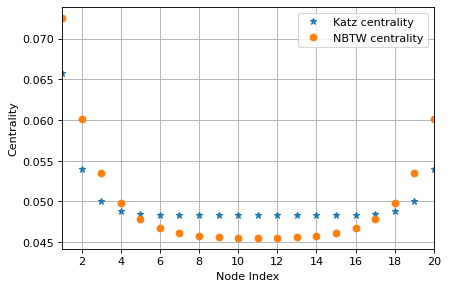

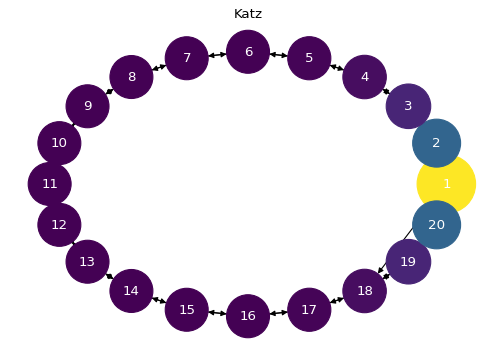

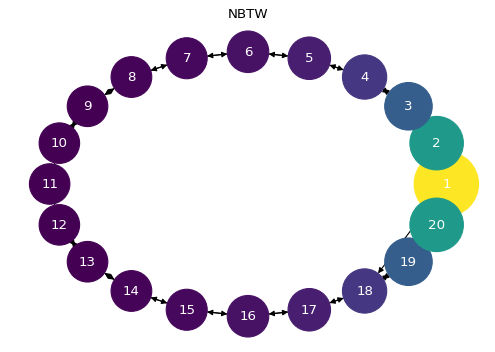

In [3]:
# Calculating Katz and NBTW for the ring example, checked with Des and it's correct
N = 20
L = 18
#L = int(np.floor(N/2+1))
A, D, S = setup_matrix(L, N)

### -----------------------------------------------------------------Katz centrality 
spec_rad1 = spec_rad(A)
#percentage = 0.3 * spec_rad1
percentage  = 0.6
alpha = percentage / spec_rad1                           # take ...% of upper limit
centrality = Katz(alpha, A, normed=True)

fig, ax = plt.subplots()
plt.plot(range(1, N+1), centrality, '*', label='Katz centrality')
plt.xlim([1, N])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


### ------------------------------------------------------------------NBTW centrality
spec_rad2 = NBTW_spec_rad(A, D, S)
t = percentage / spec_rad2                                # take ...% of upper limit
NBTWcentrality  = NBTW(t, A, D, S, normed=True)


plt.plot(range(1, N+1), NBTWcentrality, 'o', label='NBTW centrality')
plt.xlabel('Node Index')
plt.ylabel('Centrality')
plt.legend()
plt.savefig('NBTWKatz{}.pdf'.format(100*percentage))
plt.grid(True)
plt.show()


### --------------------------------------------------------------------Show graphs
# G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)

# change first label to 1 instead of 0
labeldict = {}
for i in range(N):
    labeldict[i] = i+1

create_graph(A, (centrality*800)**2, centrality)
plt.title('Katz')
plt.savefig('Katzring{}.pdf'.format(100*percentage))
plt.show()

create_graph(A, (NBTWcentrality*800)**2, NBTWcentrality)
plt.title('NBTW')
plt.savefig('NBTWring{}.pdf'.format(100*percentage))
plt.show()

In [4]:
alpha = 0.6/spec_rad(A)
t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
print(t1)
t12 = 0.6/ NBTW_spec_rad(A, D, S)
print(t12)

0.3211798486555866
0.5447459983907076


In [5]:
N = 20
L = 8
A, D, S = setup_matrix(L, N)

# NBTW
P_vvold = np.eye(N)
P_vold = A
P_old = A @ A - D
for r in range(10):
    P_new = A @ P_old + (np.eye(N) - D) @ P_vold - (A - S) @ P_vvold
    P_old = P_new
    P_vold = P_old
    P_vvold = P_vold

In [6]:
# Double neighbors graph
N=20
A2 = np.zeros((N, N))
for i in range(N-2):
    A2[i, i+1] = 1
    A2[i+1, i] = 1
    A2[i, i+2] = 1
    A2[i+2, i] = 1
A2[0, -1] = 1
A2[0, -2] = 1
A2[1, -1] = 1
A2[-1, 0] = 1
A2[-1, 1] = 1
A2[-2, 0] = 1
A2[-1, -2] = 1
A2[-2, -1] = 1

values = eig(A2)[0]
srdouble = max(abs(values))
t = 0.8 / srdouble

D = sum(A2[0,:])*np.eye(N)

labeldict = {}
for i in range(N):
    labeldict[i] = i+1
    
x = NBTW(t, A2, D, A2, normed=True)[0]
# G2 = nx.from_numpy_matrix(A2, create_using=nx.MultiDiGraph)
# nx.draw_circular(G2, node_color=x, node_size=(x*200)**3, font_color='white', labels=labeldict)
# plt.show()
print(x)

0.05000000000000001


### Numerically check new Theorem

0.5514132318673182
this should be equal to the value of t1, which is: 0.5514047103712947
3.10: 0.1389206877480389 0.6959528453803486
3.11: 2.2190203366607366 0.96


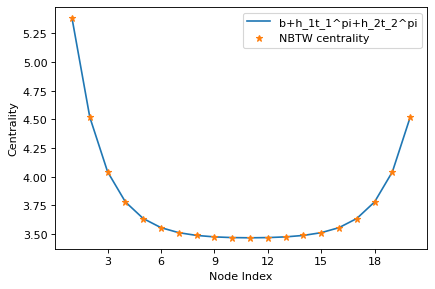

In [7]:
#---setup
N = 20
L = 8   
A, D, S = setup_matrix(L, N)
srN = NBTW_spec_rad(A, D, S)
a = 0.60 / srN 
b = (1 + a)/ (1 - a)
NBTWcentrality, t1, t2, h1, h2 = NBTW(a, A, D, S, L, approx=True)

#---checking my Thm
print((NBTWcentrality[1] - b)/(NBTWcentrality[0] - b)) # should be close to t_1
print('this should be equal to the value of t1, which is:', t1)

h = NBTWcentrality[0] - b
x = []
for i in range(1, N+1):
    pi = min(i-1, N-i+1)
    x.append(b + h * t1**pi)


# Check if equations 3.10 and 3.11 are correct
x_true = NBTWcentrality
threeten = -a * (x_true[-1] + x_true[1]) + (1 + a**2)* x_true[0] + (-a + t**3) * x_true[7]
tenrhs = 1 - a**2
if abs(threeten-tenrhs)<10**-14:
    print('3.10 klopt tot 10e-14')
print('3.10:', threeten, tenrhs)
threeeleven = -t* (x_true[11] + x_true[9]) + (1 +t**2)* x_true[10]
elevenrhs = 1 - t**2
print('3.11:', threeeleven, elevenrhs)
if abs(threeten-tenrhs)<10**-14:
    print('3.11 klopt tot 10e-14')


# check ansatz
t2 = 1/t1
ansatz = []
for i in range(1, N+1):
    pi = min(i-1, N-i+1)
    ansatz.append(b + h1 * t1**pi + h2 * t2**pi)
fig, ax = plt.subplots()
plt.plot(range(1, N+1), ansatz, label = 'b+h_1t_1^pi+h_2t_2^pi')
plt.plot(range(1, N+1), x_true, '*', label='NBTW centrality')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Node Index')
plt.ylabel('Centrality')
plt.legend()
plt.show()


difference = [abs(ansatz[i] - x_true[i]) for i in range(N)]
#print(*difference, sep = "\n") 

A, D, S = setup_matrix(L, N)

lhs = (np.eye(N) - A * a + (D - np.eye(N)) * a**2  + (A - S) * a**3) @ NBTWcentrality
rhs = (1 - a**2) * np.ones(N)
if np.all(abs(lhs - rhs))<10**-16:
    print('joepie, vector x klopt')

### Plots to put in report concerning NBTW

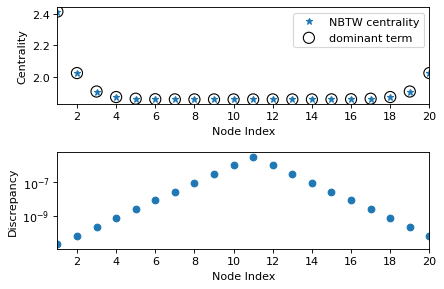

In [8]:
N = 20
L = 8
A, D, S = setup_matrix(L, N)

a = 0.3
b = (1 + a)/ (1 - a)
NBTWcentrality, t1, t2, h1, h2 = NBTW(a, A, D, S, L, approx=True)

approx = []
for i in range(1, N+1):
    pi = min(i-1, N-i+1)
    approx.append(b + h1 * t1**pi)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)     # add horizontal space between plots
 
ax1.scatter(range(1, N+1), 
            approx, 
            facecolors='none', 
            edgecolors='black', 
            s=100,
            label='dominant term')
ax1.plot(range(1, N+1), 
         NBTWcentrality, 
         '*', 
         label='NBTW centrality')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Node Index')
ax1.set_ylabel('Centrality')
ax1.set_xlim([1, N])
ax1.legend()

#--- Plot discrepancy
difference2 = [NBTWcentrality[i] - approx[i] for i in range(N)]
# print(*difference2, sep = "\n") 

plt.plot(range(1, N+1), difference2, 'o')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlim([1, N])
ax2.set_yscale('log')
plt.xlabel('Node Index')
plt.ylabel('Discrepancy')
plt.show()
fig.savefig('full{}.pdf'.format(a))

### Changing N and convergence

<ipython-input-2-f8c5db044e44>:90: LinAlgWarning: Ill-conditioned matrix (rcond=3.21011e-18): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:90: LinAlgWarning: Ill-conditioned matrix (rcond=9.82069e-21): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:90: LinAlgWarning: Ill-conditioned matrix (rcond=3.41783e-23): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:168: LinAlgWarning: Ill-conditioned matrix (rcond=7.35659e-17): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:90: LinAlgWarning: Ill-conditioned matrix (rcond=1.044e-25): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:168: LinAlgWarning: Ill-conditioned matrix (rcond=1.19311e-18): result may not be accurate.
  h = solve(left, right)
<ipython-input-2-f8c5db044e44>:90: LinAlgWarning: Ill-conditioned matrix (rcond=3.62958e-28): result may not be accura

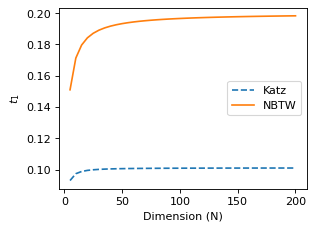

In [9]:
tk = []
tn = []
Ns = []
percentage = 0.2
Nrange = range(5, 200+1, 5)

for N in Nrange:
    if N%2 == 0:
        L = int(np.floor(N/2+1))
    else:
        L = int(np.floor((N+1)/2))
    A, D, S = setup_matrix(L, N)
    
    srK = spec_rad(A)
    a = percentage / srK
    
    spec_radius2 = NBTW_spec_rad(A, D, S)
    t = percentage / spec_radius2
    
    t11 = Katz(a, A, L, approx=True, normed=True)[1]
    t21 = NBTW(t, A, D, S, L, approx=True, normed=True)[1]
    tk.append(t11)
    tn.append(t21)
    Ns.append(N)
    
from matplotlib.pyplot import figure

figure(figsize = (4,3))
plt.plot(Ns, tk, '--', label='Katz')
plt.plot(Ns, tn, label='NBTW')
plt.ylabel(r'$t_1$')
plt.xlabel('Dimension (N)')
plt.legend()
plt.savefig('t1_ring_dim.pdf', bbox_inches = "tight")
plt.show()

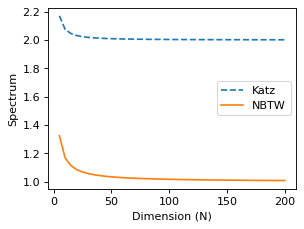

In [37]:
Krad = []
Nrad = []

for N in Nrange:
    if N%2 == 0:
        L = int(np.floor(N/2+1))
    else:
        L = int(np.floor((N+1)/2))
    A, D, S = setup_matrix(L, N)
    
    Krad.append(spec_rad(A))
    Nrad.append(NBTW_spec_rad(A,D,S))

figure(figsize = (4,3))
plt.plot(Ns, Krad, '--', label='Katz')
plt.plot(Ns, Nrad, label='NBTW')
plt.ylabel('Spectrum')
plt.xlabel('Dimension (N)')
plt.legend()
plt.savefig('spec_ring_dim.pdf', bbox_inches = "tight")
plt.show()    

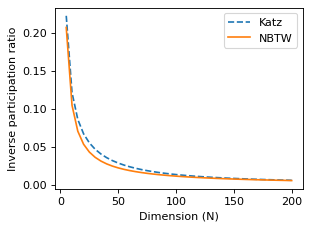

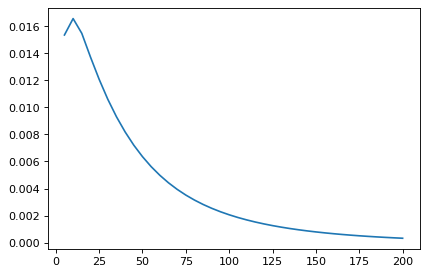

In [12]:
loc_k = []
loc_n = []
percentage = 0.95

for N in Nrange:
    if N%2 == 0:
        L = int(np.floor(N/2+1))
    else:
        L = int(np.floor((N+1)/2))
    
    A, D, S = setup_matrix(L, N)
    
    a = percentage / spec_rad(A)
    t = percentage / NBTW_spec_rad(A, D, S)
    
    xk = Katz(a, A, L, normed=True)
    xn = NBTW(t, A, D, S, L, normed=True)

    xk /= LA.norm(xk)
    xn /= LA.norm(xn)
    
    loc_k.append(sum([i**4 for i in xk]))
    loc_n.append(sum([i**4 for i in xn]))

figure(figsize = (4,3))
plt.plot(Ns, loc_k, '--', label='Katz')
plt.plot(Ns, loc_n, label='NBTW')
plt.ylabel('Inverse participation ratio')
plt.xlabel('Dimension (N)')
plt.legend()
plt.savefig('loc_ring_dim.pdf', bbox_inches = "tight")
plt.show()


diff = [abs(loc_k[i]-loc_n[i]) for i in range(len(Ns))]
plt.plot(Ns, diff)

### Comparing $t_1$ for the same downweighting parameter

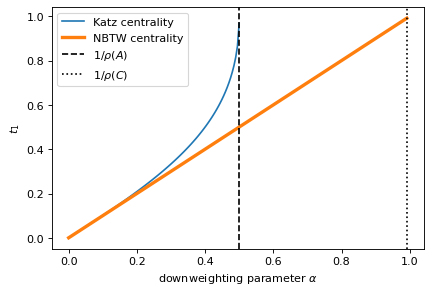

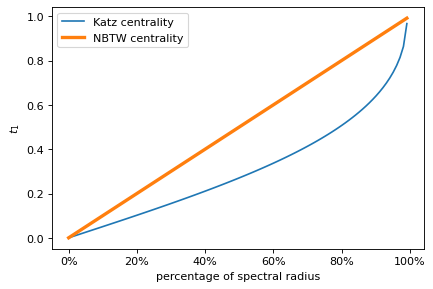

0.9190078506188245


In [11]:
t1k = []
t1n = []
arangeK = np.linspace(0.0001, 1/spec_rad(A), 100)
arangeN = np.linspace(0.0001, 1/spec_radius2, 100)
for a in arangeK:
    t1k.append((1-np.sqrt(1-4*a**2))/(2*a))

for a in arangeN:
    t1n.append(a)
       
plt.plot(arangeK, t1k, label='Katz centrality')
plt.plot(arangeN, t1n, label='NBTW centrality', linewidth=3)
plt.axvline(x=1/srK, linestyle='--', label = r'$1/\rho(A)$', color = 'black')
plt.axvline(x=1/spec_radius2, linestyle=':', label = r'$1/\rho(C)$', color = 'black')
plt.legend()
plt.xlabel(r'downweighting parameter $\alpha$')
plt.ylabel(r'$t_1$')
plt.savefig('spectrum.pdf')
plt.show()

fig, ax = plt.subplots()
plt.plot(arangeN*100, t1k, label='Katz centrality')
plt.plot(arangeN*100, t1n, label='NBTW centrality', linewidth=3)
plt.legend()
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('percentage of spectral radius')
plt.ylabel(r'$t_1$')
#plt.title(r'$t_1$ for different percentages of the spectal radius')
plt.savefig('spectrum2.pdf')
plt.show()
print(1/spec_rad2)

### Localisation

In [12]:
N = 20
L = 8
A, D, S = setup_matrix(L, N)

perc = 0.4
print('we take', perc, 'of the spectrum')
a = perc/spec_rad(A)
Katzhoi = Katz(a, A, L)
Katznorm = Katzhoi/LA.norm(Katzhoi, 2)
Katz_loc = sum([i**4 for i in Katznorm])
print('localisation Katz:', Katz_loc)

t = perc/NBTW_spec_rad(A,D,S)
NBTWhoi = NBTW(t, A, D, S)
NBTWnorm = NBTWhoi/LA.norm(NBTWhoi, 2)
NBTW_loc = sum([i**4 for i in NBTWnorm])
print('localisation NBTW:', NBTW_loc)

we take 0.4 of the spectrum
localisation Katz: 0.05050535260794145
localisation NBTW: 0.05167205018711351


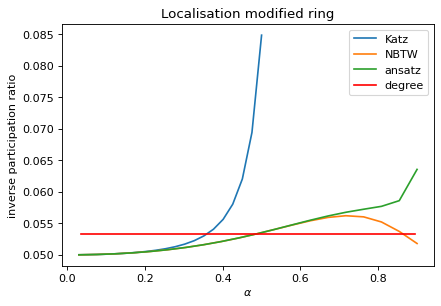

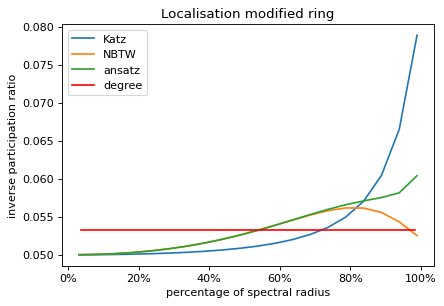

In [13]:
N = 20
L = 8
A, D, S = setup_matrix(L, N)

# Plot localisaion
K_loc = []
N_loc = []
a_loc = []
for percentage in np.linspace(0.03, 1/(NBTW_spec_rad(A, D, S)-0.01), 20):
    
    NBTWCen, t1, t2, h1, h2 = NBTW(percentage, A, D, S, L, approx=True)
    normedNBTW = NBTWCen / LA.norm(NBTWCen, 2)
    N_loc.append(sum(normedNBTW**4))
    
    b = (1 + percentage)/ (1 - percentage)

    approx = []
    for i in range(1, N+1):
        pi = min(i-1, N-i+1)
        approx.append(b + h1 * t1**pi)
    normedApprox = approx / LA.norm(approx, 2)
    a_loc.append(sum(normedApprox**4))

for percentage in np.linspace(0.03, 1/(spec_rad(A)-0.01), 20):
    
    katzCen = Katz(percentage, A)
    normedKatz = katzCen / LA.norm(katzCen, 2)
    K_loc.append(sum(normedKatz**4))

degree = A @ np.ones(N)
normed_diag = degree / LA.norm(degree, 2)
D_loc = sum(normed_diag**4)
    
fig, ax = plt.subplots()
plt.plot(np.linspace(0.03, 0.5, 20), K_loc, label='Katz')
plt.plot(np.linspace(0.03, 0.9, 20), N_loc, label='NBTW')
plt.plot(np.linspace(0.03, 0.9, 20), a_loc, label='ansatz')
plt.axhline(y=D_loc, xmin=0.05, xmax=0.95, label='degree', c='r')
plt.title('Localisation modified ring')
plt.xlabel(r'$\alpha$')
plt.ylabel('inverse participation ratio')
plt.legend()
plt.savefig('loc_ring_fixed_a.pdf')
plt.show()


# Plot localisaion
K_loc = []
N_loc = []
a_loc = []
for percentage in np.linspace(0.03, 0.99, 20):
    
    t = percentage / NBTW_spec_rad(A, D, S)
    NBTWCen, t1, t2, h1, h2 = NBTW(t, A, D, S, L, approx=True)
    normedNBTW = NBTWCen / LA.norm(NBTWCen, 2)        # 2norm=1 needed for localization
    N_loc.append(sum(normedNBTW**4))
    
    a = percentage / spec_rad(A)
    katzCen = Katz(a, A)
    normedKatz = katzCen / LA.norm(katzCen, 2)
    K_loc.append(sum(normedKatz**4))
    
    b = (1 + t)/ (1 - t)

    approx = []
    for i in range(1, N+1):
        pi = min(i-1, N-i+1)
        approx.append(b + h1 * t1**pi)
    normedApprox = approx / LA.norm(approx, 2)
    a_loc.append(sum(normedApprox**4))

degree = A @ np.ones(N)
normed_diag = degree / LA.norm(degree, 2)
D_loc = sum(normed_diag**4)
    
fig, ax = plt.subplots()
plt.plot(np.linspace(3, 99, 20), K_loc, label='Katz')
plt.plot(np.linspace(3, 99, 20), N_loc, label='NBTW')
plt.plot(np.linspace(3, 99, 20), a_loc, label='ansatz')
plt.axhline(y=D_loc, xmin=0.05, xmax=0.95, label='degree', c='r')
plt.title('Localisation modified ring')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('percentage of spectral radius')
plt.ylabel('inverse participation ratio')
plt.legend()
plt.savefig('loc_ring_perc_a.pdf')
plt.show()  

spectral radius of C is: 1.0881299864050546
mu is: 0.9190078506188245
mu coming from M(t) is [0.7642169]
0.9190078506188245 (0.7642169007416102+0j)


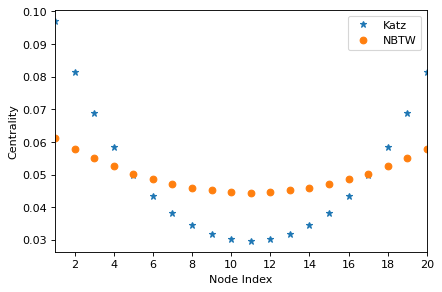

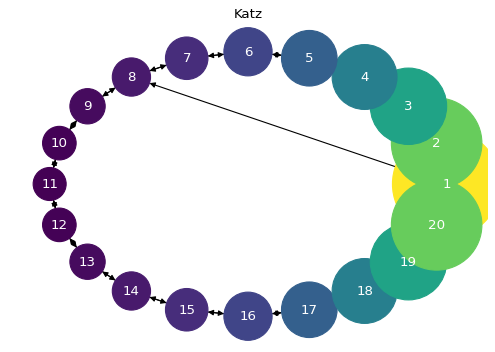

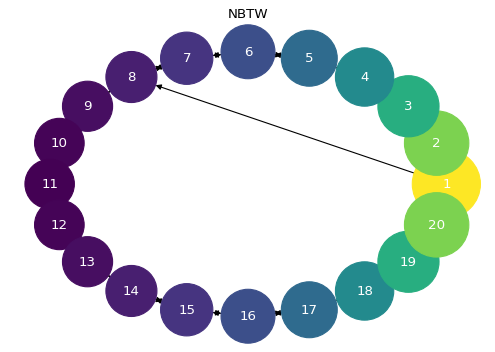

In [14]:
from numpy.linalg import eig
import scipy

N = 20
L = 8
A, D, S = setup_matrix(L, N)

percentage = 0.99999999
sr = NBTW_spec_rad(A, D, S)
print('spectral radius of C is:', sr)
t = percentage / sr 
a = percentage / spec_rad(A)
mu = 1 / sr
print('mu is:', mu)

M = np.eye(N) - A * t + (D - np.eye(N)) * t**2 + (A - S) * t**3

Meigs, Mvecs = scipy.sparse.linalg.eigs(M, k=1, sigma=mu)
print('mu coming from M(t) is', Meigs.real)

posM = []
for i in Meigs:
    if i>0:
        posM.append(i)
mu2 = min(posM)
k = list(Meigs).index(mu2)
x = Mvecs[k]
x /= LA.norm(x)

print(mu, mu2)

fig, ax = plt.subplots()
Katzcentrality = Katz(a, A, L, normed=True)
NBTWcentrality = NBTW(t, A, D, S, L, normed=True)
plt.plot(range(1, N+1), Katzcentrality, '*', label='Katz')
plt.plot(range(1, N+1), NBTWcentrality, 'o', label='NBTW')
plt.xlim([1, N])
plt.xlabel('Node Index')
plt.ylabel('Centrality')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot()
plt.legend()
plt.savefig('eigenvector.pdf')
plt.show()

create_graph(A, (Katzcentrality*1000)**2, Katzcentrality)
plt.title('Katz')
plt.show()
create_graph(A, (NBTWcentrality*1000)**2, NBTWcentrality)
plt.title('NBTW')
plt.show()